In [1]:
!pip install tensorflow-gpu
!pip install gdown

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
import joblib

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
!gdown --id 1aRXGcJlIkuC6uj1iLqzi9DQQS-3GPwM_ --output airbnb_nyc.csv

Downloading...
From: https://drive.google.com/uc?id=1aRXGcJlIkuC6uj1iLqzi9DQQS-3GPwM_
To: /Users/idagon/Desktop/Deploy-Keras-Deep-Learning-Model-with-Flask-master/price_prediction/airbnb_nyc.csv
7.08MB [00:01, 4.32MB/s]


In [4]:
df = pd.read_csv('airbnb_nyc.csv')

# Exploration

In [5]:
df.shape

(48895, 16)

In [6]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

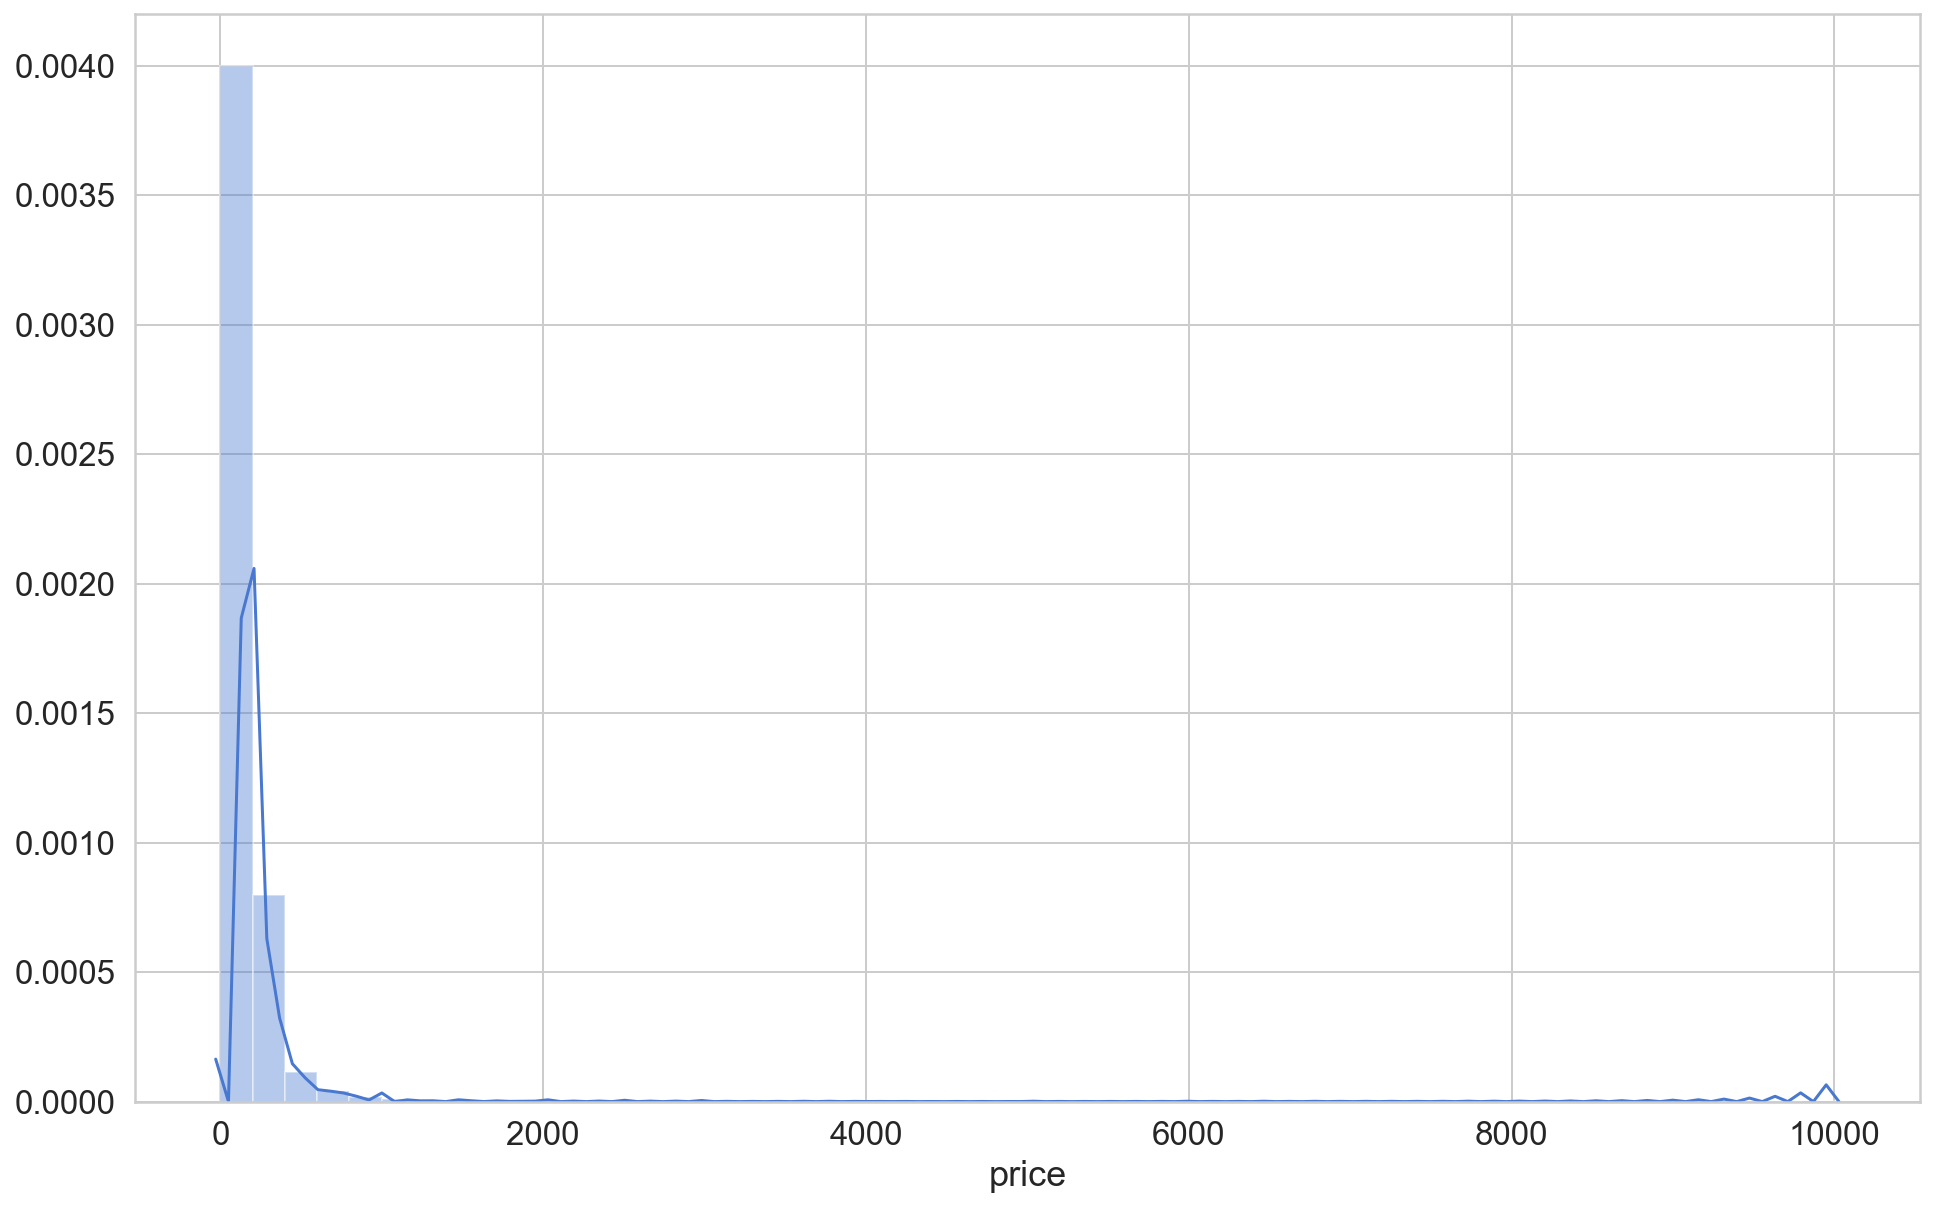

In [7]:
sns.distplot(df.price);

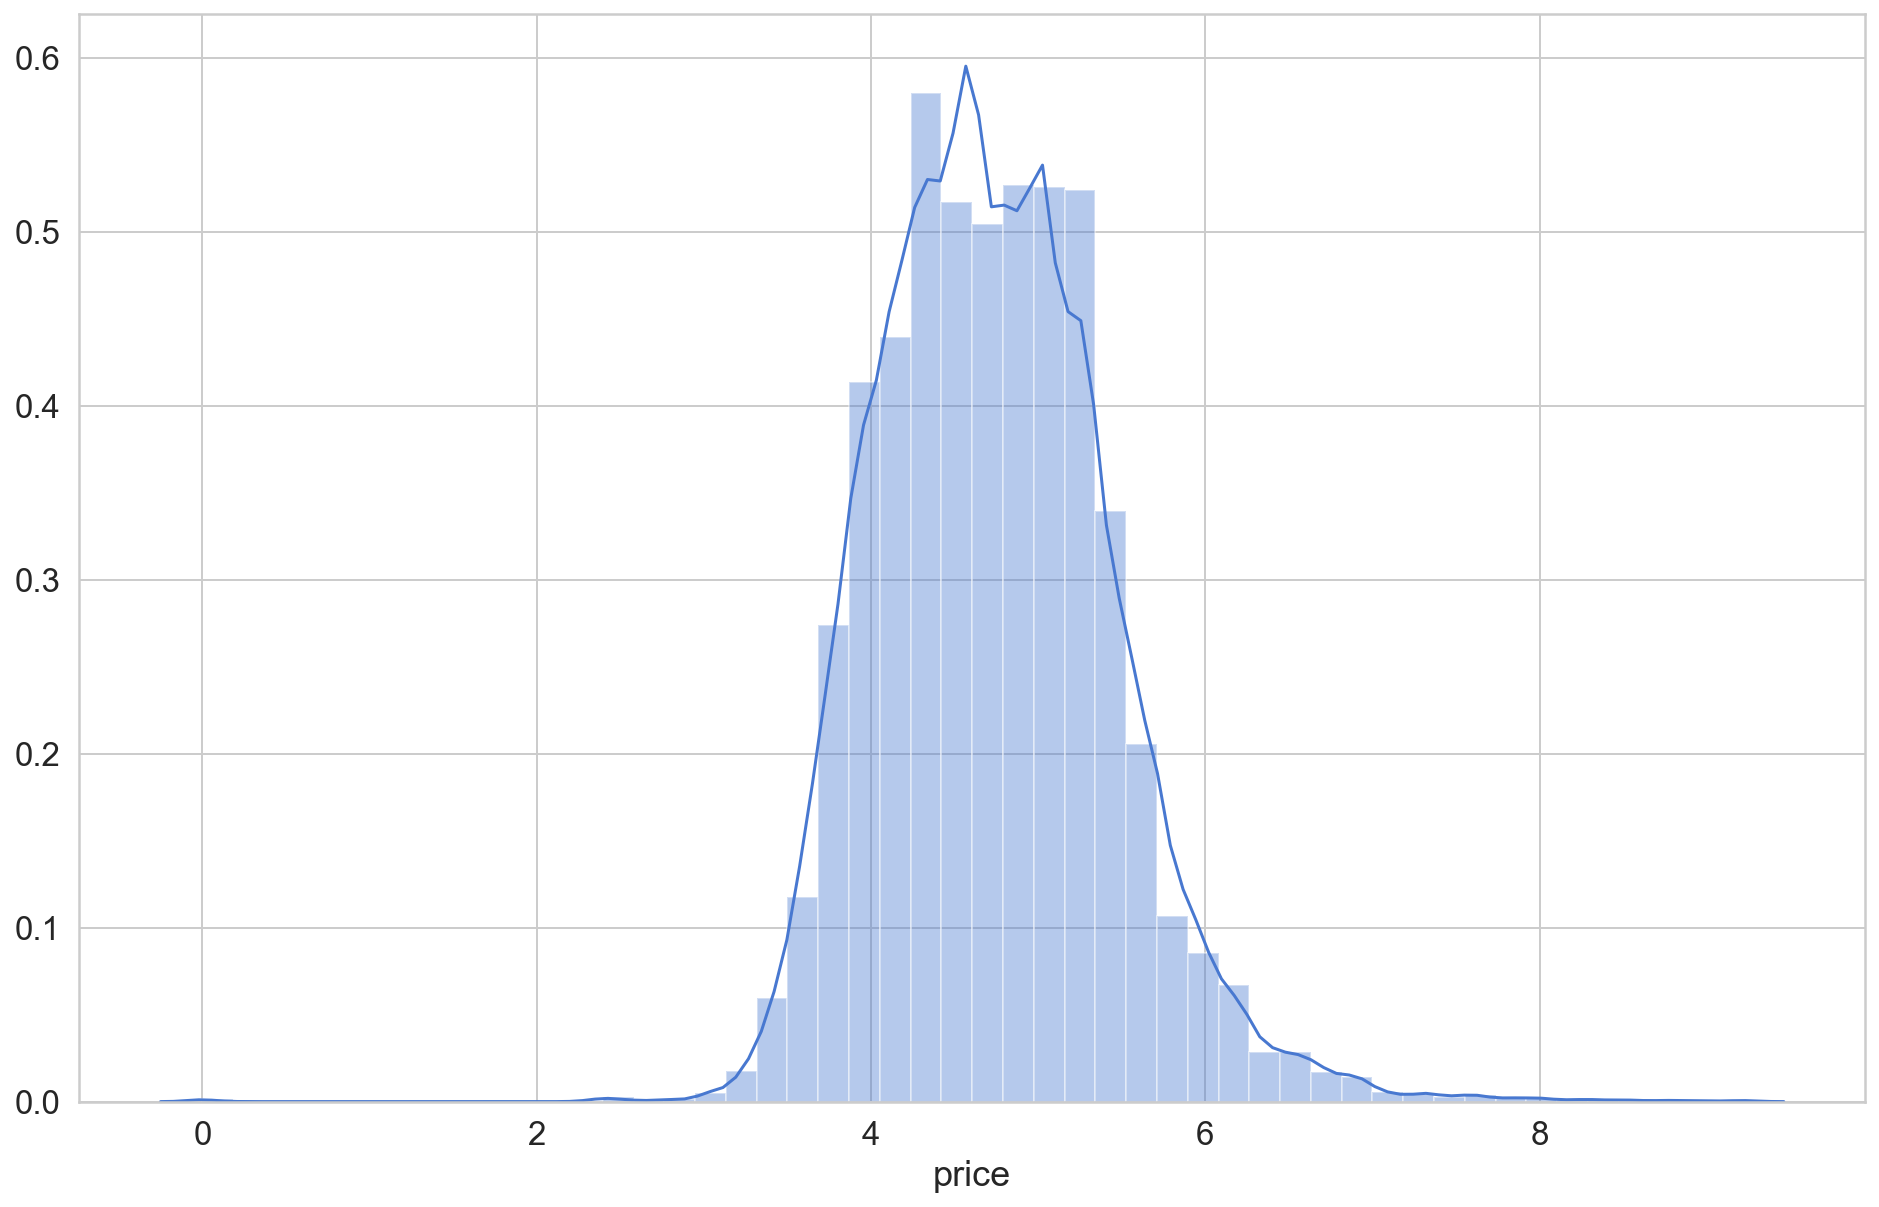

In [8]:
sns.distplot(np.log1p(df.price));

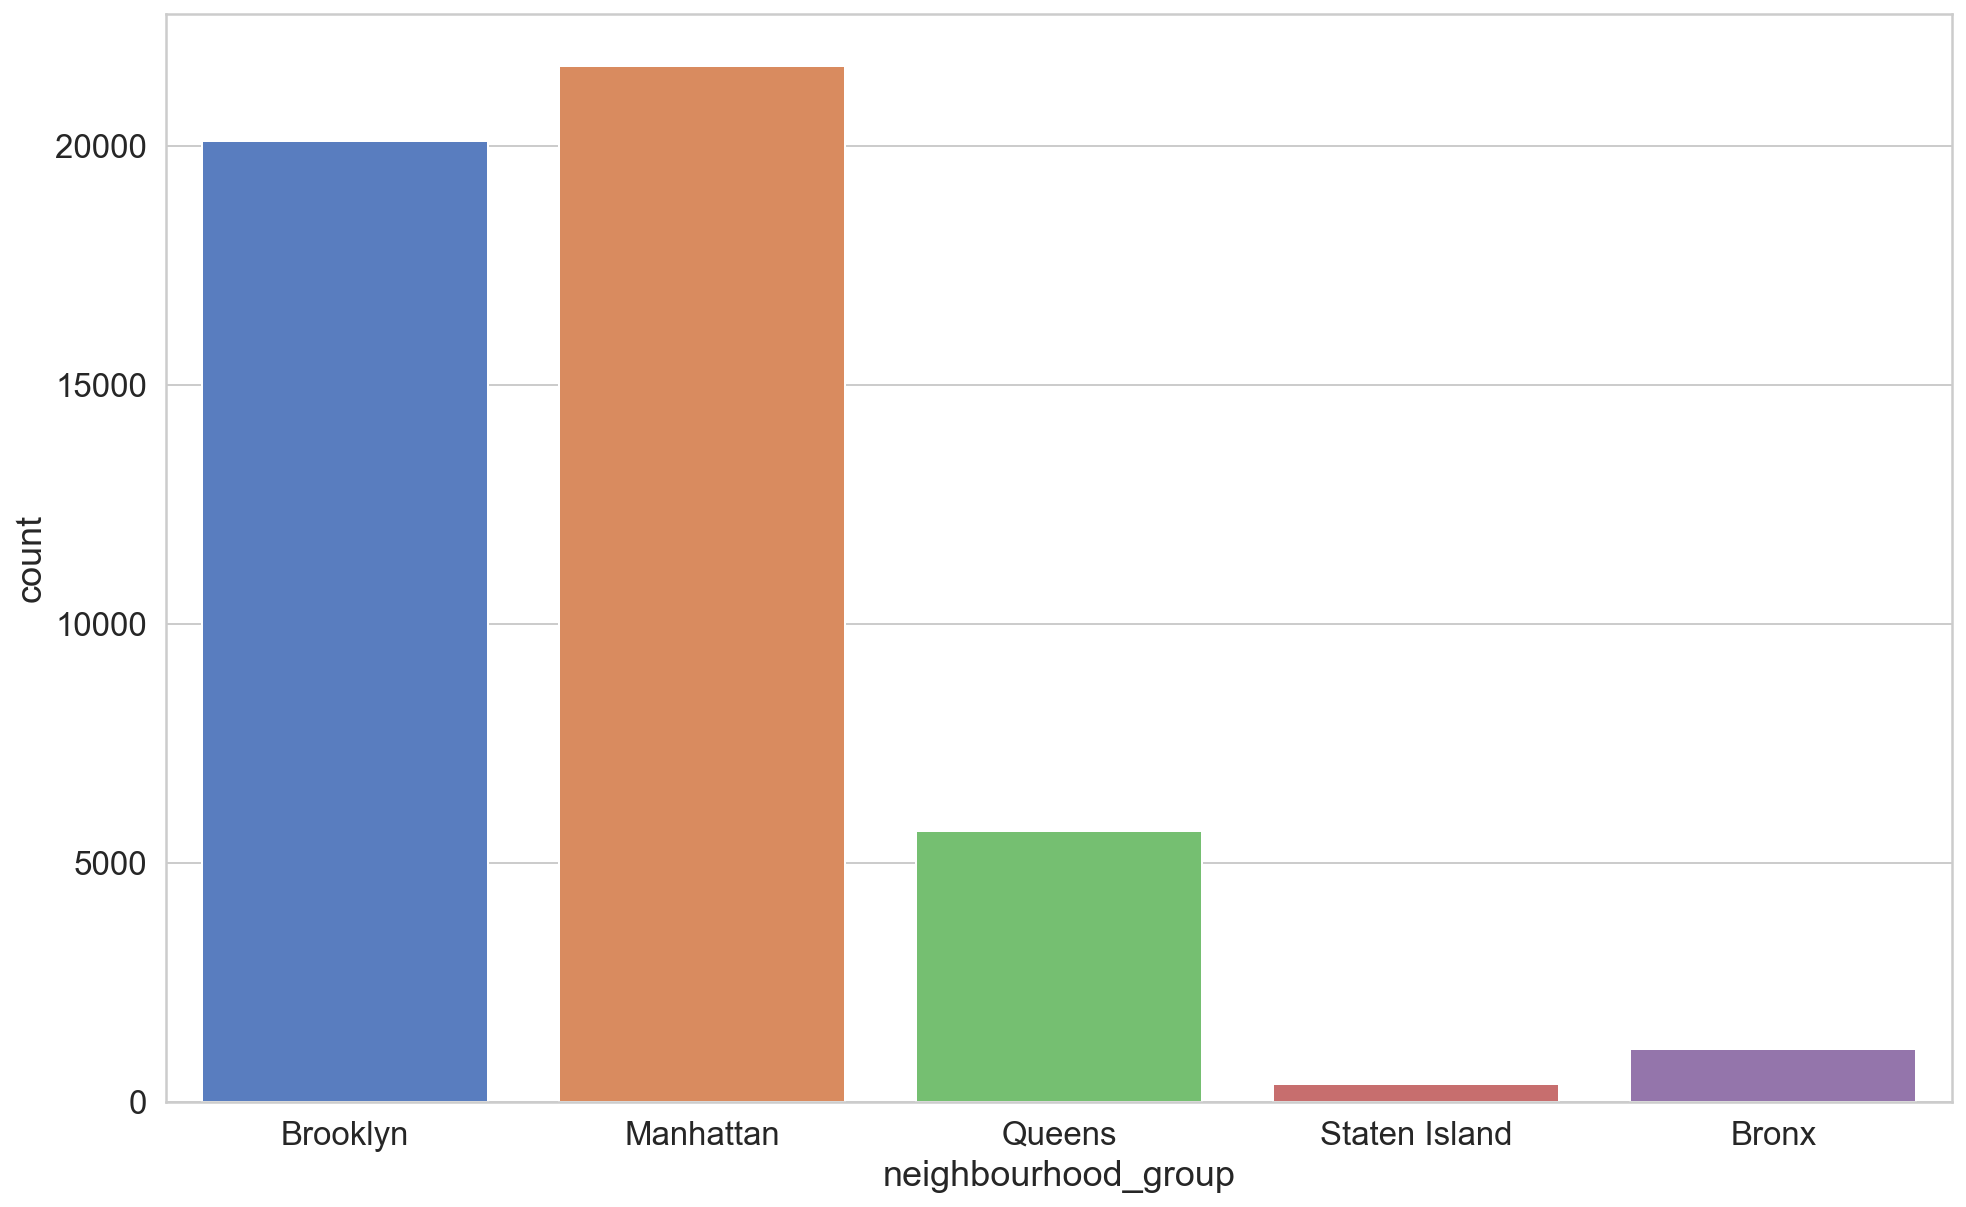

In [9]:
sns.countplot(x='neighbourhood_group', data=df);

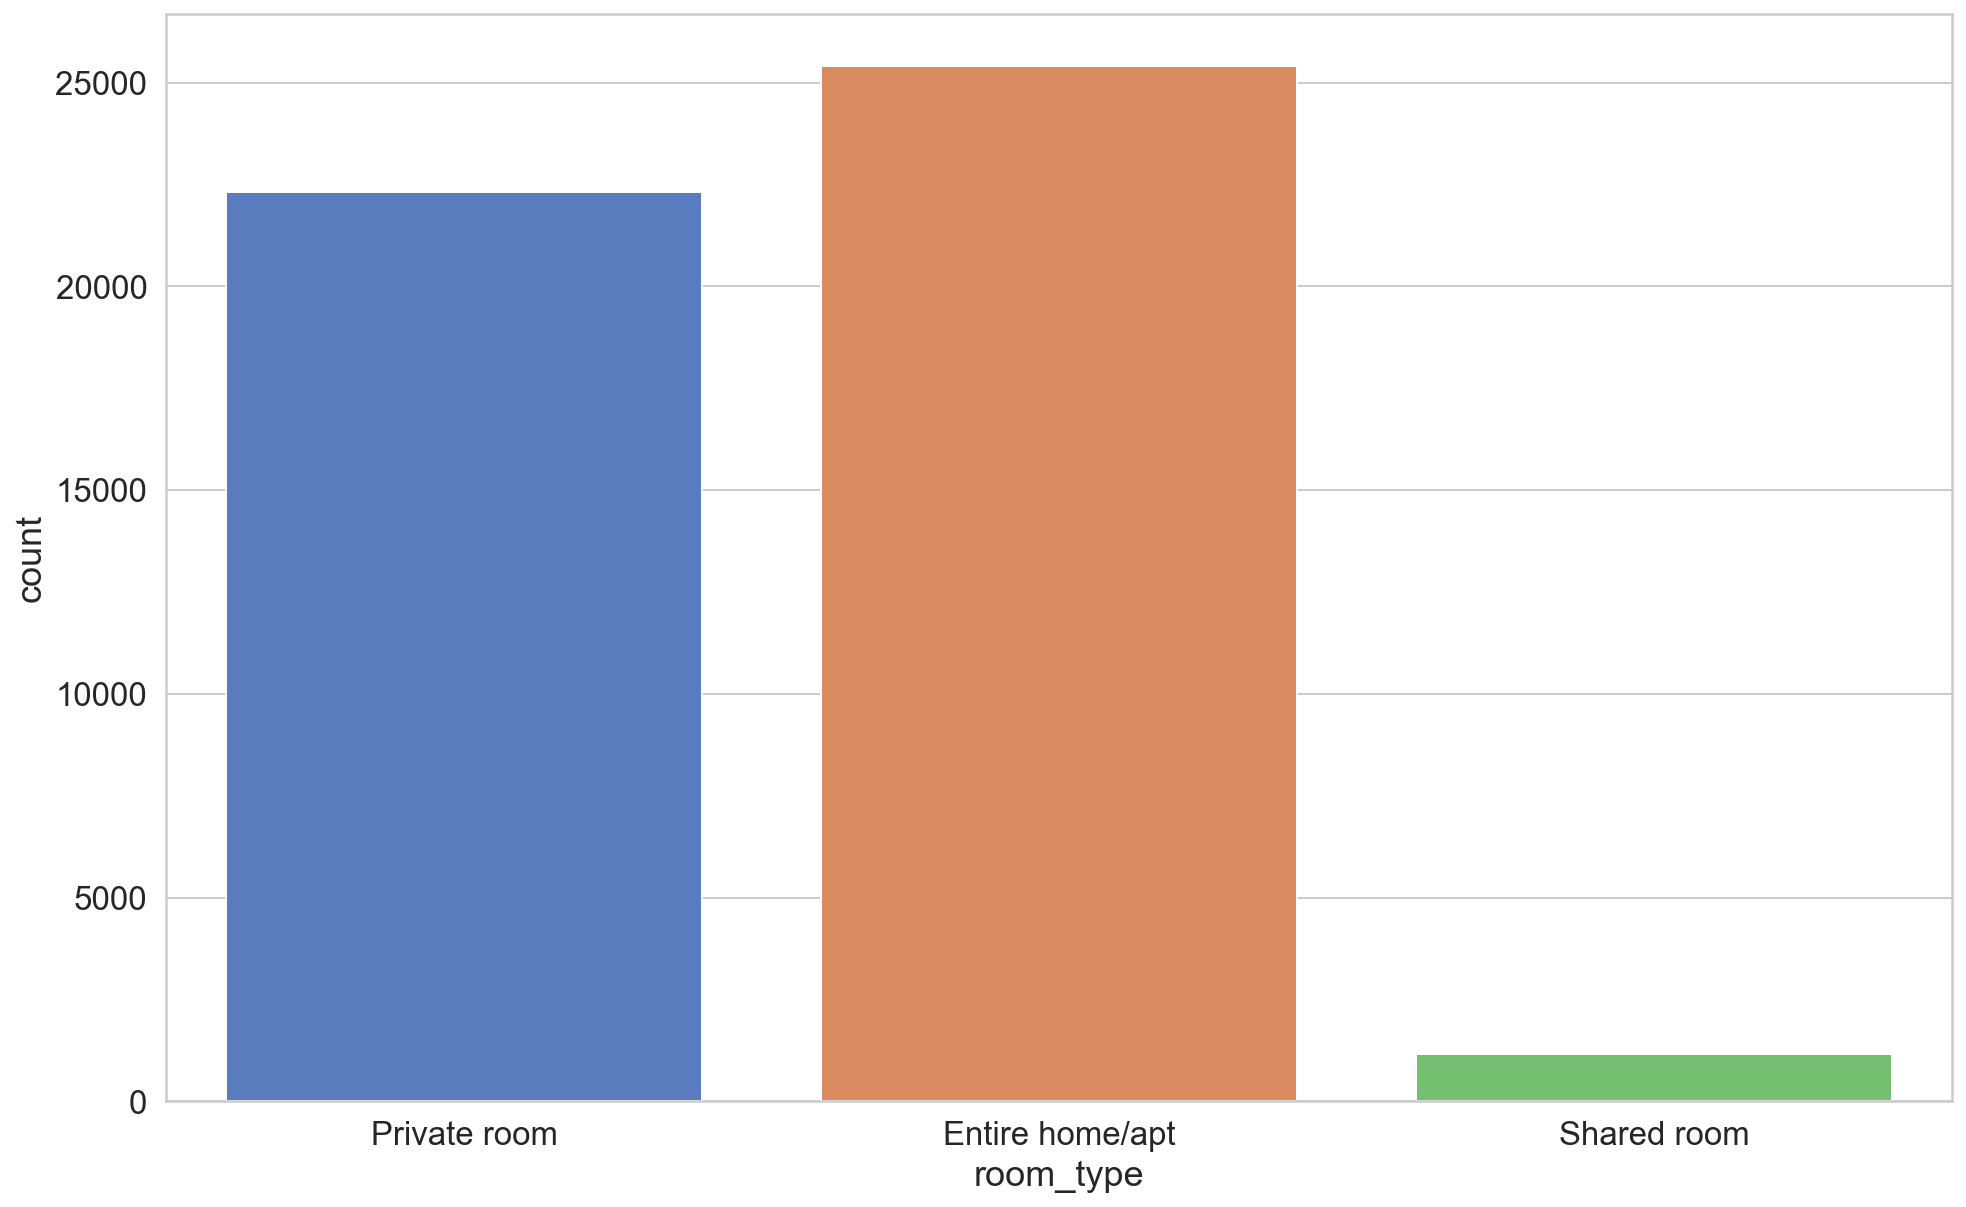

In [10]:
sns.countplot(x='room_type', data=df);

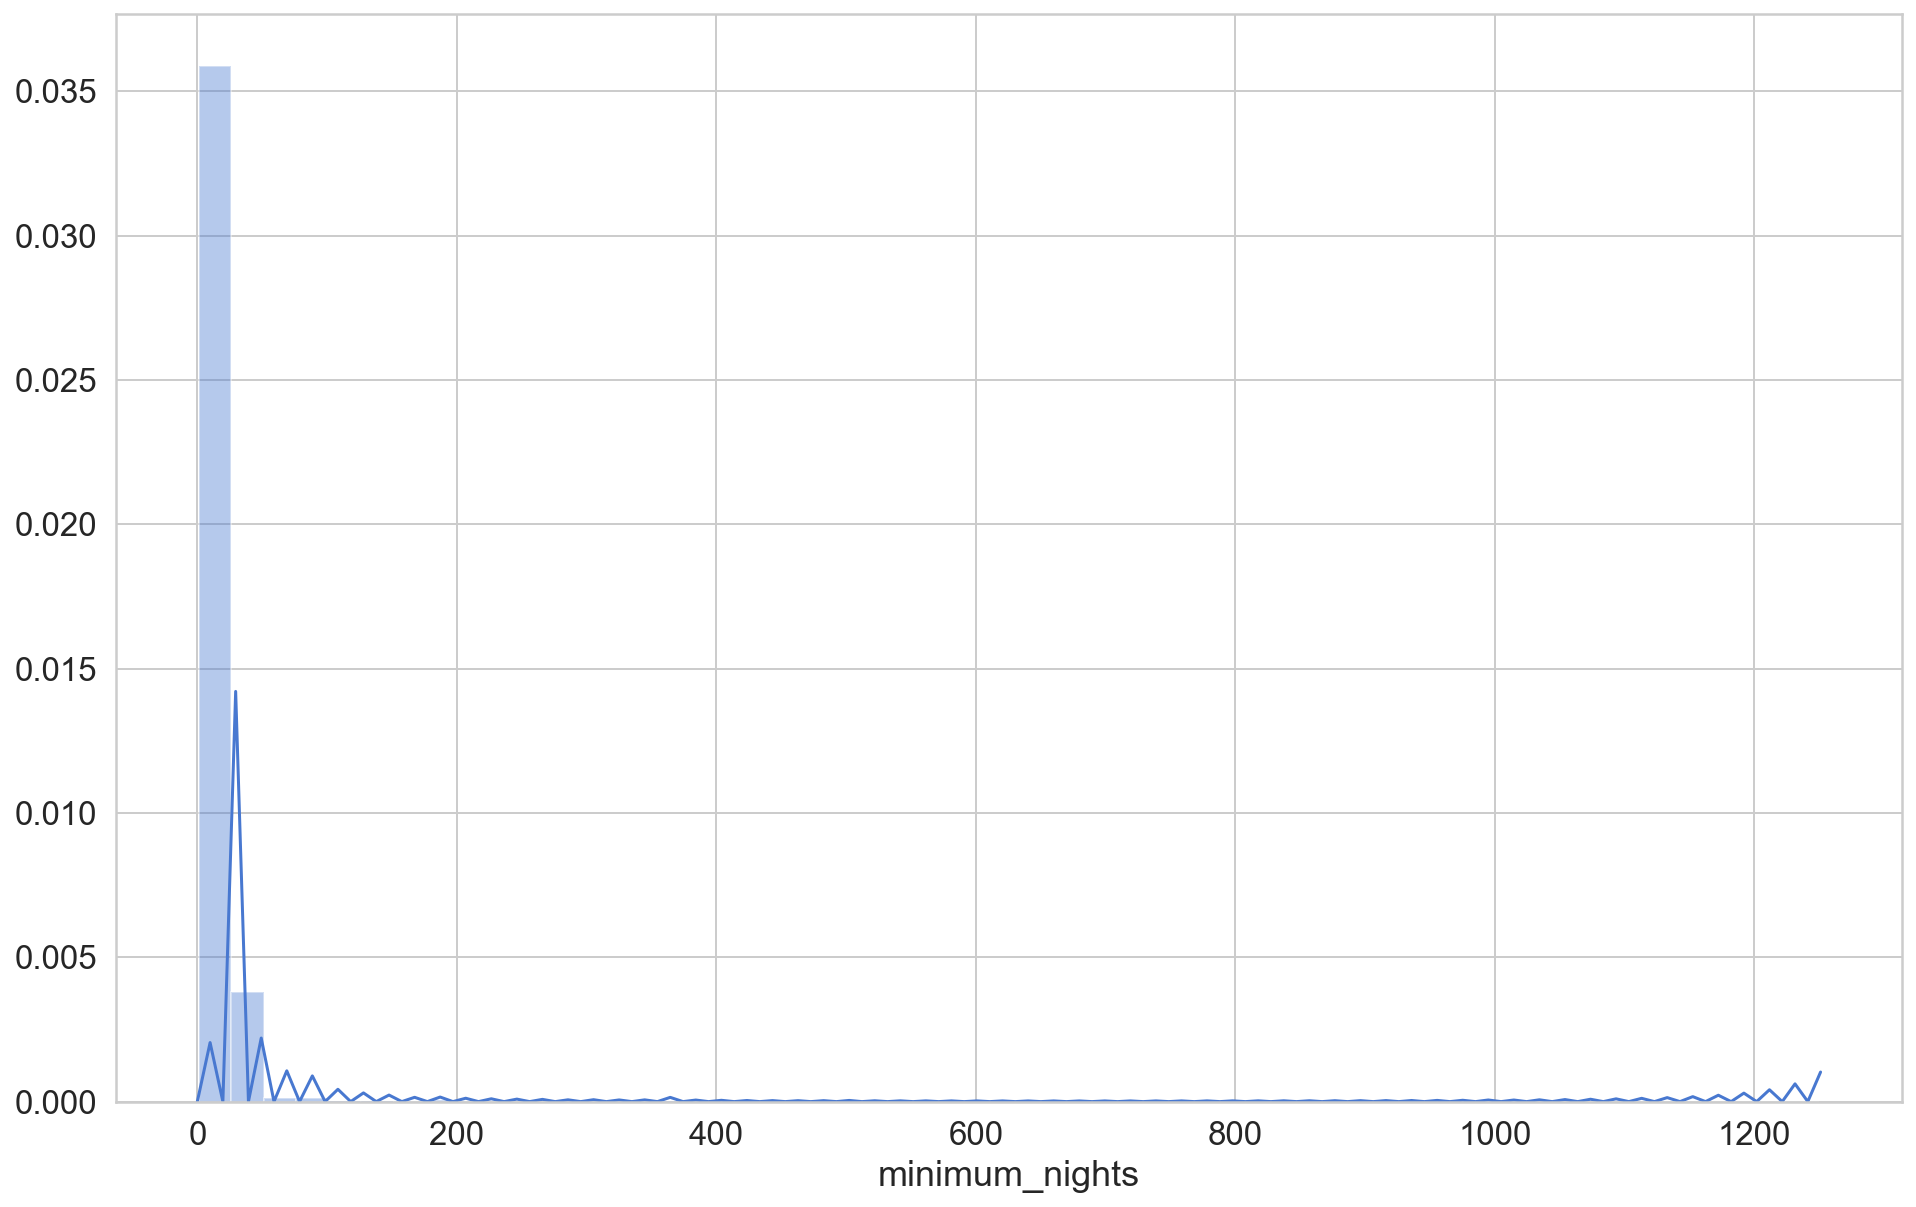

In [11]:
sns.distplot(df.minimum_nights);

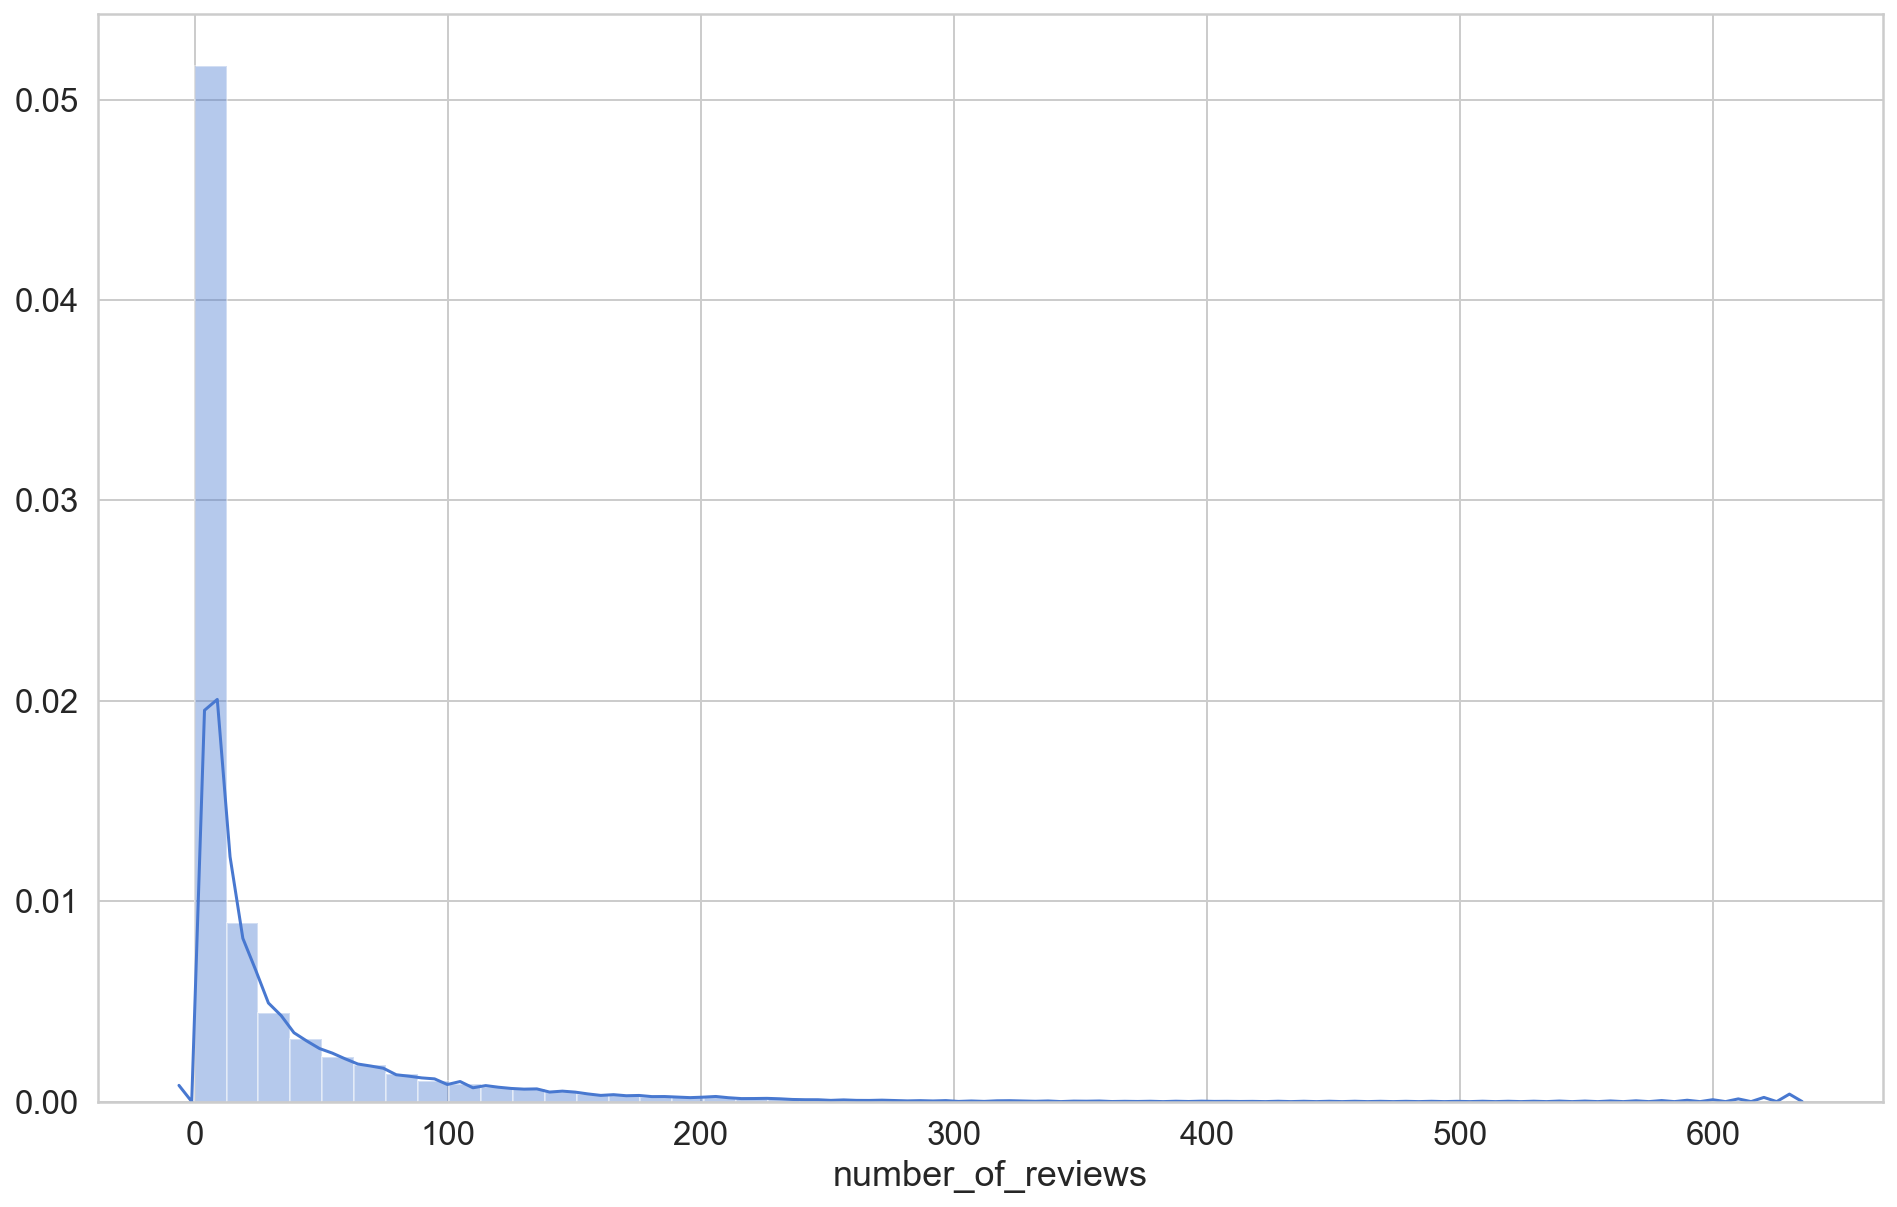

In [12]:
sns.distplot(df.number_of_reviews);

In [13]:
corr_matrix = df.corr()

In [14]:
price_corr = corr_matrix['price']
price_corr.iloc[price_corr.abs().argsort()]

id                                0.010619
host_id                           0.015309
reviews_per_month                -0.030608
latitude                          0.033939
minimum_nights                    0.042799
number_of_reviews                -0.047954
calculated_host_listings_count    0.057472
availability_365                  0.081829
longitude                        -0.150019
price                             1.000000
Name: price, dtype: float64

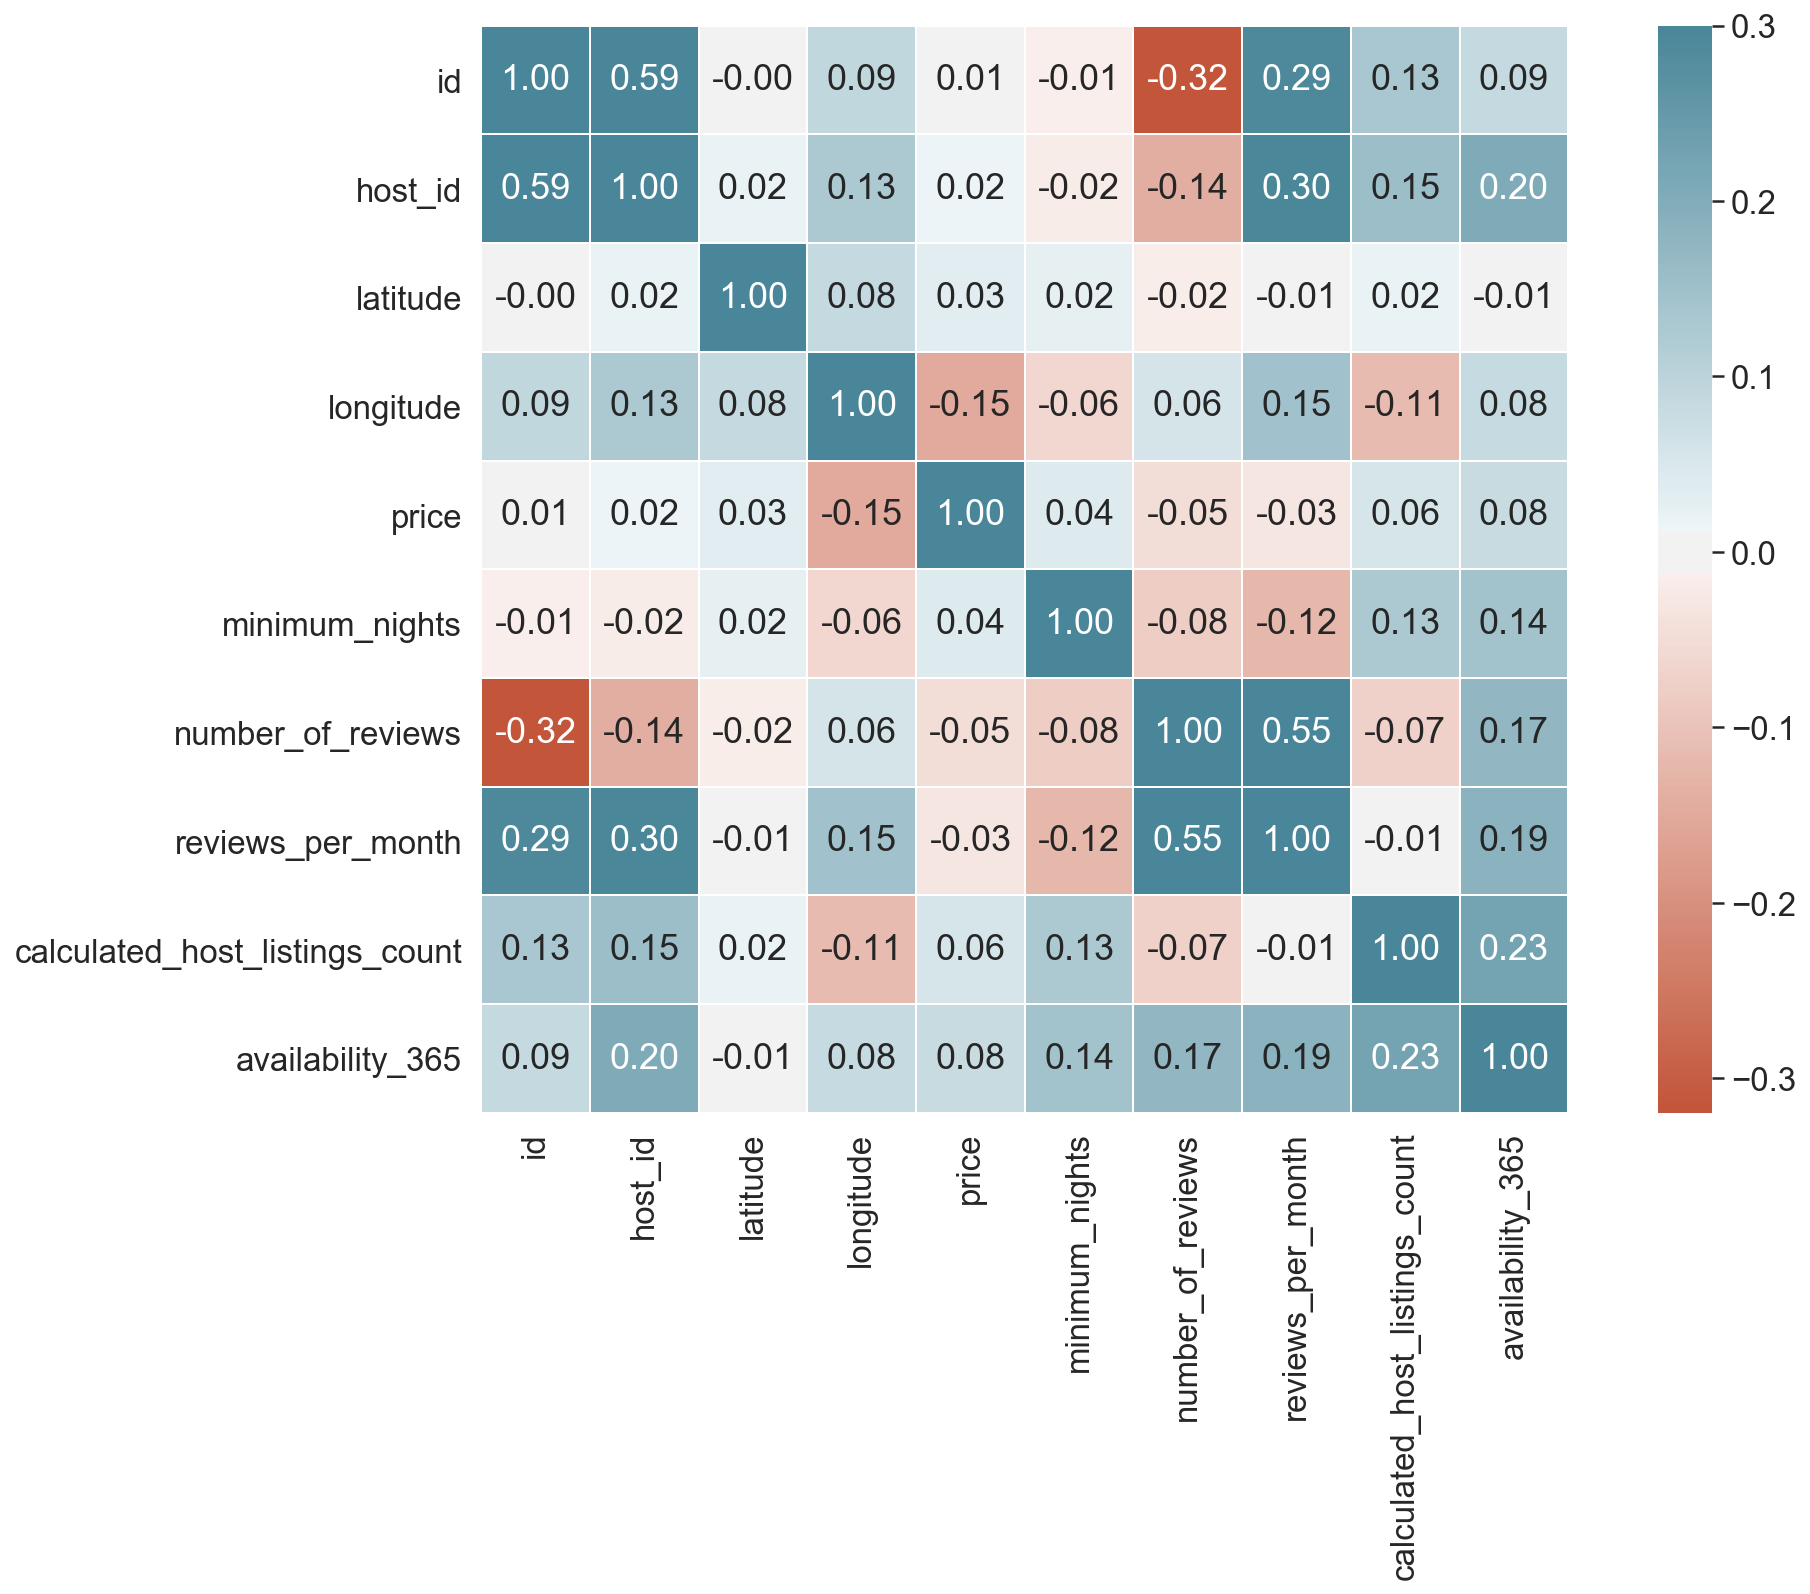

In [15]:
palette = sns.diverging_palette(20, 220, n=256)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5);

# Preprocessing




## Missing data?

In [16]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

reviews_per_month    10052
last_review          10052
host_name               21
name                    16
dtype: int64

## Remove unused columns!


In [17]:
df = df.drop(['id', 'name', 'host_id', 'host_name', 'reviews_per_month', 'last_review', 'neighbourhood'], axis=1)

In [18]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [19]:
df.columns

Index(['neighbourhood_group', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [20]:
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,1,0


## Predict log1p

In [21]:
X = df.drop('price', axis=1)
y = np.log1p(df.price.values)

## Feature scaling and One-hot encoding

In [22]:
from sklearn.preprocessing import OneHotEncoder

data = [['Manhattan'], ['Brooklyn']]

OneHotEncoder(sparse=False).fit_transform(data)

array([[0., 1.],
       [1., 0.]])

In [23]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (MinMaxScaler(), ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']),
    (OneHotEncoder(handle_unknown="ignore"), ['neighbourhood_group', 'room_type'])
)

In [24]:
transformer.fit(X)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('minmaxscaler',
                                 MinMaxScaler(copy=True, feature_range=(0, 1)),
                                 ['latitude', 'longitude', 'minimum_nights',
                                  'number_of_reviews',
                                  'calculated_host_listings_count',
                                  'availability_365']),
                                ('onehotencoder',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               sparse=True),
                                 ['neighbourhood_group', 'room_type'])],
                  verbose=False)

In [25]:
X = transformer.transform(X)

## Split the training and test data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [27]:
X_train.shape

(39116, 14)

# Modeling

In [28]:
def plot_mse(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.plot(hist['epoch'], hist['mse'],
            label='Train MSE')
  plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val MSE')
  plt.legend()
  plt.show()

Train on 31292 samples, validate on 7824 samples
Epoch 1/100
31292/31292 [==============================] - 2s 51us/sample - loss: 8.7079 - mse: 8.7079 - val_loss: 0.5533 - val_mse: 0.5533
Epoch 2/100
31292/31292 [==============================] - 1s 32us/sample - loss: 2.3689 - mse: 2.3689 - val_loss: 0.4569 - val_mse: 0.4569
Epoch 3/100
31292/31292 [==============================] - 1s 31us/sample - loss: 2.1296 - mse: 2.1296 - val_loss: 0.4418 - val_mse: 0.4418
Epoch 4/100
31292/31292 [==============================] - 1s 32us/sample - loss: 2.0007 - mse: 2.0007 - val_loss: 0.4275 - val_mse: 0.4275
Epoch 5/100
31292/31292 [==============================] - 1s 31us/sample - loss: 1.9427 - mse: 1.9427 - val_loss: 0.4257 - val_mse: 0.4257
Epoch 6/100
31292/31292 [==============================] - 1s 31us/sample - loss: 1.8758 - mse: 1.8758 - val_loss: 0.4258 - val_mse: 0.4258
Epoch 7/100
31292/31292 [==============================] - 1s 31us/sample - loss: 1.8158 - mse: 1.8158 - val_lo

Epoch 59/100
31292/31292 [==============================] - 1s 34us/sample - loss: 0.3130 - mse: 0.3130 - val_loss: 0.2523 - val_mse: 0.2523
Epoch 60/100
31292/31292 [==============================] - 1s 33us/sample - loss: 0.3126 - mse: 0.3126 - val_loss: 0.2510 - val_mse: 0.2510
Epoch 61/100
31292/31292 [==============================] - 1s 33us/sample - loss: 0.3031 - mse: 0.3031 - val_loss: 0.2507 - val_mse: 0.2507
Epoch 62/100
31292/31292 [==============================] - 1s 33us/sample - loss: 0.2980 - mse: 0.2980 - val_loss: 0.2477 - val_mse: 0.2477
Epoch 63/100
31292/31292 [==============================] - 1s 33us/sample - loss: 0.2968 - mse: 0.2968 - val_loss: 0.2492 - val_mse: 0.2492
Epoch 64/100
31292/31292 [==============================] - 1s 32us/sample - loss: 0.2952 - mse: 0.2952 - val_loss: 0.2474 - val_mse: 0.2474
Epoch 65/100
31292/31292 [==============================] - 1s 32us/sample - loss: 0.2879 - mse: 0.2879 - val_loss: 0.2463 - val_mse: 0.2463
Epoch 66/100


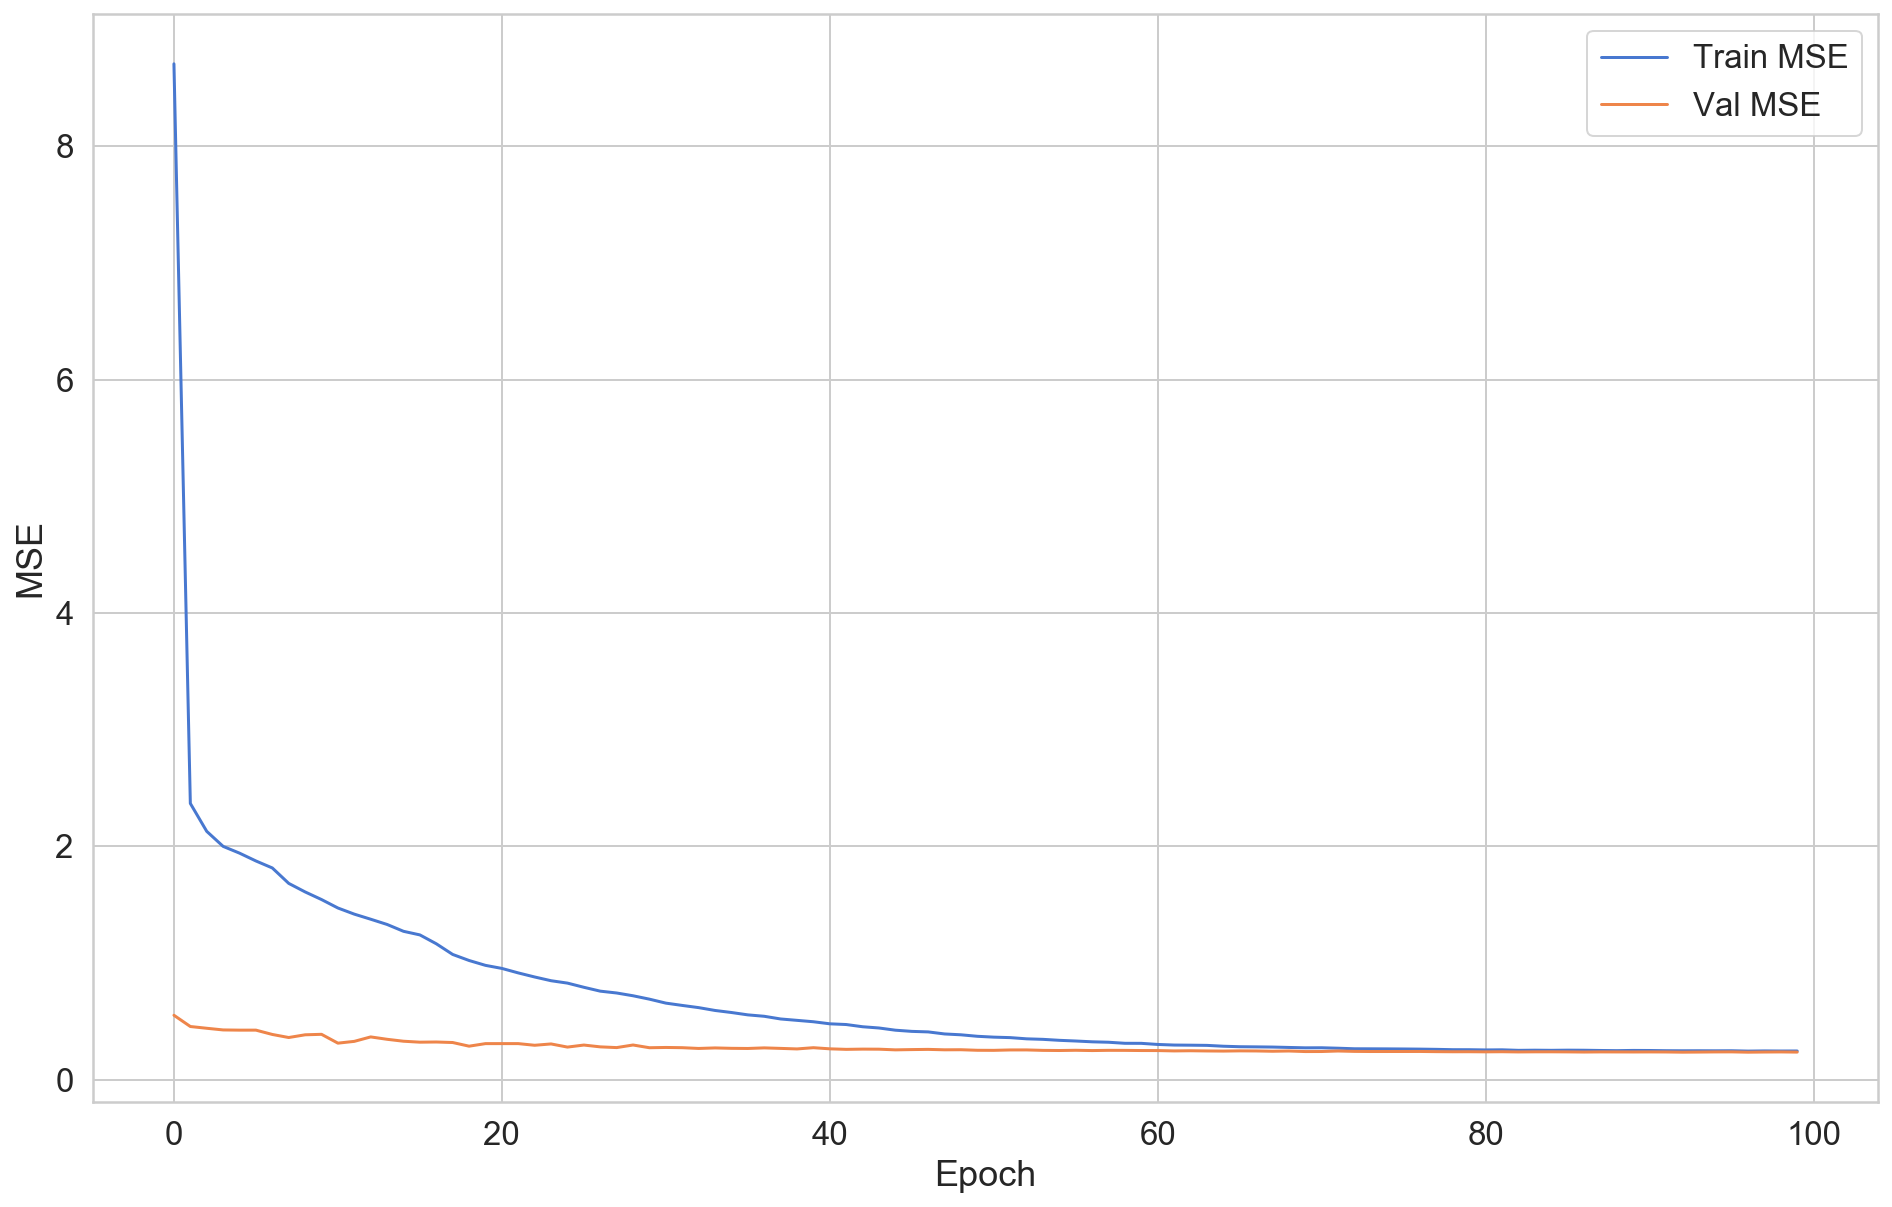

In [29]:
model = keras.Sequential()
model.add(keras.layers.Dense(units=64, activation="relu", input_shape=[X_train.shape[1]]))
model.add(keras.layers.Dropout(rate=0.3))
model.add(keras.layers.Dense(units=32, activation="relu"))
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(1))

model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss = 'mse', 
    metrics = ['mse'])

BATCH_SIZE = 32

early_stop = keras.callbacks.EarlyStopping(
  monitor='val_mse',
  mode="min",
  patience=10
)

history = model.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=100,
  validation_split=0.2,
  batch_size=BATCH_SIZE,
  callbacks=[early_stop]
)

plot_mse(history)

# Evaluation

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

In [31]:
y_pred = model.predict(X_test)

In [32]:
f'MSE {mean_squared_error(y_test, y_pred)}'

'MSE 0.213855636027282'

In [33]:
f'MAE {mean_absolute_error(y_test, y_pred)}'

'MAE 0.33320172888759336'

In [34]:
f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}'

'RMSE 0.4624452789544748'

In [35]:
f'R2 {r2_score(y_test, y_pred)}'

'R2 0.5479577128946871'

# Saving

In [36]:
joblib.dump(transformer, "data_transformer.joblib")
model.save("price_prediction_model.h5")

In [0]:
from google.colab import files

In [0]:
files.download("data_transformer.joblib")
files.download("price_prediction_model.h5") 